# import files

In [1]:
import numpy as np

import pandas as pd

import xarray as xr

import glob

import matplotlib as mpl

import matplotlib.pyplot as plt

import math as mt

from math import e

import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint

from scipy.signal import hilbert
import statistics


# Read Fog file

In [3]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')


In [37]:
plt.figure(figsize=[16,8])

#fogData.fogdata

#fogData.fogdata.sum(dim=['stations','months','days']).plot()
#fogData.fogdata.sum(dim=['stations','months','days'])


<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [36]:
StackFog=fogData.fogdata.stack(a=('years','months','days'))
#StackFog

In [6]:
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
    

In [35]:
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
# fogData.fogdata.values.shape
# fogData.stations
#plt.figure(figsize=[16,8])
#fg.fogdata.resample(time="1y").sum().sum(dim='stations').plot()
#fg.fogdata.time

# Read ERA5 Data

In [8]:
t2mData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_t2m_3hourly_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_u10_3hourly_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_v10_3hourly_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_d2m_3hourly_NovDecJan.nc')

In [55]:
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
u10D = u10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
v10D = v10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
d2mD = d2mData.sel(latitude=slice(32,24),longitude=slice(74,86))

# Calculate wind speed and relative humidity

In [33]:
ws = ((v10D.v10[:,0,:,:].values**2)+(u10D.u10[:,0,:,:].values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
rh = (e**((17.625*(d2mD.d2m[:,0,:,:].values-273.15))/(243.04+(d2mD.d2m[:,0,:,:].values-273.15)))/e**((17.625*(t2mD.t2m[:,0,:,:].values-273.15))/(243.04+(t2mD.t2m[:,0,:,:].values-273.15))))
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
#rh_ds
             
    

# Read 850 data

In [11]:
tz850Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_850_tqz_3hourly_NovDecJan.nc')
uv850Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_850_uv_3hourly_NovDecJan.nc')
tz850D = tz850Data.sel(latitude=slice(32,24),longitude=slice(74,86))
uv850D = uv850Data.sel(latitude=slice(32,24),longitude=slice(74,86))

# Calculate inv

In [12]:
inv=t2mD.t2m[:,0,:,:].values-tz850D.t[:,0,:,:].values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'
#inv_ds.inv

In [38]:
l = np.arange(-10,11,1)

#inv_ds.inv[0,:,:].plot(levels=l,extend='both',cmap='bwr')

# u shear calculation

In [39]:
ushear=(uv850D.u[:,0,:,:].values-u10D.u10[:,0,:,:].values)/(tz850D.z[:,0,:,:].values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

#ushear_ds.ushear
#inv

# Read W700 

In [15]:
w700Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_700_w_3hourly_NovDecJan.nc')
w700D = w700Data.sel(latitude=slice(32,24),longitude=slice(74,86))

# Hilbert Vars                                    

In [67]:
w700_hb = np.imag(hilbert(w700D.w.values[(t2mData.t2m.time.dt.year<2020),0,:,:],axis=0))
w700_hb_ds = xr.Dataset({'w700_hb': (('time','latitude','longitude'), w700_hb)}, 
                    coords={'time': v10D.time[(t2mData.t2m.time.dt.year<2020)],
                           'latitude': v10D.latitude,
                          'longitude': v10D.longitude})


t2m_hb = np.imag(hilbert(t2mD.t2m.values[(t2mData.t2m.time.dt.year<2020),0,:,:],axis=0))
t2m_hb_ds = xr.Dataset({'t2m_hb': (('time','latitude','longitude'), t2m_hb)}, 
                    coords={'time': v10D.time[(t2mData.t2m.time.dt.year<2020)],
                           'latitude': v10D.latitude,
                          'longitude': v10D.longitude})

ws_hb = np.imag(hilbert(ws_ds.ws.values[(ws_ds.ws.time.dt.year<2020),:,:],axis=0))
ws_hb_ds = xr.Dataset({'ws_hb': (('time','latitude','longitude'), ws_hb)}, 
                    coords={'time': v10D.time[(ws_ds.ws.time.dt.year<2020)],
                           'latitude': v10D.latitude,
                          'longitude': v10D.longitude})

inv_hb = np.imag(hilbert(inv_ds.inv.values[(inv_ds.inv.time.dt.year<2020),:,:],axis=0))
inv_hb_ds = xr.Dataset({'inv_hb': (('time','latitude','longitude'), inv_hb)}, 
                    coords={'time': v10D.time[(inv_ds.inv.time.dt.year<2020)],
                           'latitude': v10D.latitude,
                          'longitude': v10D.longitude})

ushear_hb = np.imag(hilbert(ushear_ds.ushear.values[(ushear_ds.ushear.time.dt.year<2020),:,:],axis=0))
ushear_hb_ds = xr.Dataset({'ushear_hb': (('time','latitude','longitude'), ushear_hb)}, 
                    coords={'time': v10D.time[(ushear_ds.ushear.time.dt.year<2020)],
                           'latitude': v10D.latitude,
                          'longitude': v10D.longitude})

rh_hb = np.imag(hilbert(rh_ds.rh.values[(rh_ds.rh.time.dt.year<2020),:,:],axis=0))
rh_hb_ds = xr.Dataset({'rh_hb': (('time','latitude','longitude'), rh_hb)}, 
                    coords={'time': v10D.time[(rh_ds.rh.time.dt.year<2020)],
                           'latitude': v10D.latitude,
                          'longitude': v10D.longitude})



# Read Orography


In [16]:
OroData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/ERA5IGP_Orography.nc')
OroData.data_vars
OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))

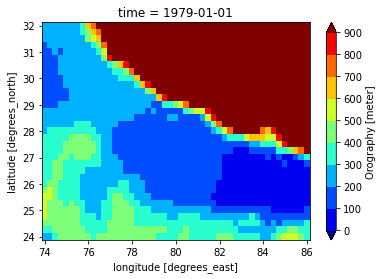

In [17]:
oro = OroD.z
oro.values = OroD.z.values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
l = np.arange(0,1000,100)
oro[0,:,:].plot(levels=l,extend='both',cmap='jet')

# Create Mask altitude >500 m NaN

In [18]:
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values
# chk mask
t2mD.t2m.values=t2mD.t2m.values*mask
#t2mData.t2m[0,0,:,:].plot(cmap='jet')
#plt.figure(figsize=[20,10])
#t2mData.mean(dim=['latitude','longitude']).t2m[:,0].plot()
t2mTS=t2mD.mean(dim=['latitude','longitude'], skipna=True).t2m[:,0]


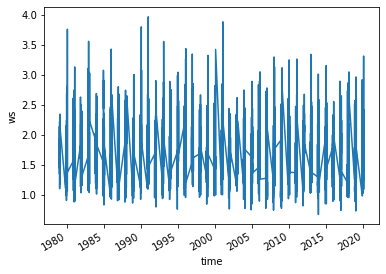

In [19]:
ws_ds.ws.values=ws_ds.ws.values*mask
wsTS=ws_ds.mean(dim=['latitude','longitude'], skipna=True).ws
wsTS.plot()


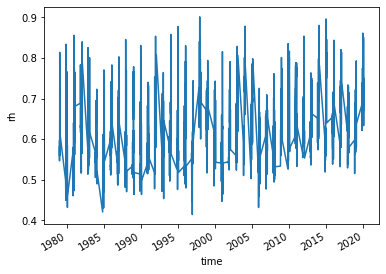

In [20]:
rh_ds.rh.values=rh_ds.rh.values*mask
rh_ds.rh[:].mean(dim=['latitude','longitude'], skipna=True).plot()


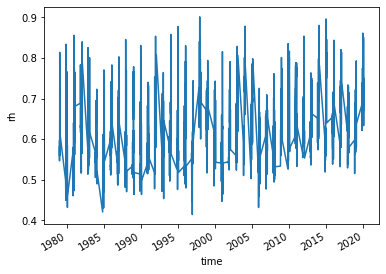

In [21]:
rhTS=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh
rhTS.plot()

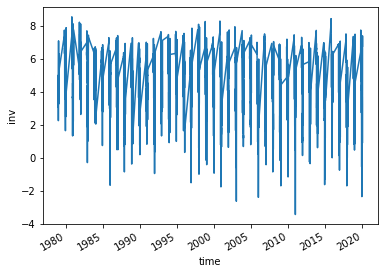

In [22]:
inv_ds.inv.values=inv_ds.inv.values*mask
invTS=inv_ds.mean(dim=['latitude','longitude'], skipna=True).inv
invTS.plot()

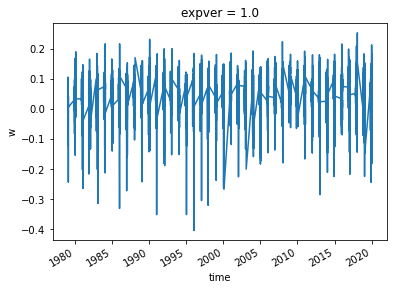

In [23]:
w700D.w.values=w700D.w.values*mask
w700D.mean(dim=['latitude','longitude'])
wTS=w700D.mean(dim=['latitude','longitude'], skipna=True).w[:,0]
wTS.plot()

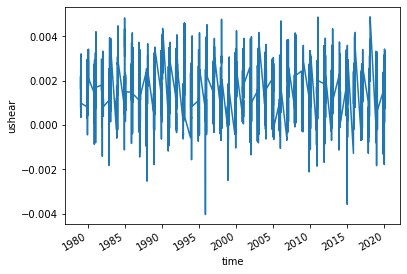

In [24]:
ushear_ds.ushear.values=ushear_ds.ushear.values*mask
ushearTS=ushear_ds.mean(dim=['latitude','longitude'], skipna=True).ushear
ushearTS.plot()

In [78]:
t2m_hb_ds.t2m_hb.values=t2m_hb_ds.t2m_hb.values*mask
t2m_hbTS=t2m_hb_ds.mean(dim=['latitude','longitude'], skipna=True).t2m_hb
#t2m_hbTS.plot()

inv_hb_ds.inv_hb.values=inv_hb_ds.inv_hb.values*mask
inv_hbTS=inv_hb_ds.mean(dim=['latitude','longitude'], skipna=True).inv_hb
#inv_hbTS.plot()

ws_hb_ds.ws_hb.values=ws_hb_ds.ws_hb.values*mask
ws_hbTS=ws_hb_ds.mean(dim=['latitude','longitude'], skipna=True).ws_hb
#ws_hbTS.plot()

ushear_hb_ds.ushear_hb.values=ushear_hb_ds.ushear_hb.values*mask
ushear_hbTS=ushear_hb_ds.mean(dim=['latitude','longitude'], skipna=True).ushear_hb
#ushear_hbTS.plot()

rh_hb_ds.rh_hb.values=rh_hb_ds.rh_hb.values*mask
rh_hbTS=rh_hb_ds.mean(dim=['latitude','longitude'], skipna=True).rh_hb
#rh_hbTS.plot()

w700_hb_ds.w700_hb.values=w700_hb_ds.w700_hb.values*mask
w700_hbTS=w700_hb_ds.mean(dim=['latitude','longitude'], skipna=True).w700_hb
#w700_hbTS.plot()


#  Create area averaged values and get same days as fog days i.e. Dec Jan

In [77]:
# a,b = xr.align(fg.fogdata.sum(dim='stations'),t2mTS)


t2m=t2mTS[((t2mTS.time.dt.month>11) | (t2mTS.time.dt.month<2)) & (t2mTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
ws=wsTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
inv=invTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
rh=rhTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
w=wTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
ushear=ushearTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

# fg.fogdata.sum(dim='stations')


In [83]:
t2mhb=t2m_hbTS[((t2m_hb_ds.time.dt.month>11) | (t2m_hb_ds.time.dt.month<2)) 
                       & (t2m_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

invhb=inv_hbTS[((inv_hb_ds.time.dt.month>11) | (inv_hb_ds.time.dt.month<2))
                       & (inv_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

wshb=ws_hbTS[((ws_hb_ds.time.dt.month>11) | (ws_hb_ds.time.dt.month<2))
                    & (ws_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

rhhb=rh_hbTS[((rh_hb_ds.time.dt.month>11) | (rh_hb_ds.time.dt.month<2))
                    & (rh_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

whb=w700_hbTS[((w_hb_ds.time.dt.month>11) | (w_hb_ds.time.dt.month<2))
                 & (w_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

ushearhb=ushear_hbTS[((ushear_hb_ds.time.dt.month>11)
                                 | (ushear_hb_ds.time.dt.month<2))
                                & (ushear_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

In [84]:
 X       = pd.DataFrame([t2m.values,ws.values,rh.values,inv.values,w.values,ushear.values*100.0,
                        t2mhb.values,wshb.values,rhhb.values,invhb.values,whb.values,ushearhb.values]).T[:]
 X.index = pd.to_datetime(t2m.time.values)
X

,0,1,2,3,4,5,6,7,8,9,10,11
1979-12-01 10:30:00,1.718231,1.834932,0.708859,6.891872,0.098325,0.090997,3.601679,0.038903,0.151368,-0.546598,-0.012106,2.694765e-04
1979-12-02 10:30:00,1.739563,1.639527,0.666631,5.898264,0.054857,0.109640,3.807241,0.014750,0.129374,-0.232701,0.019394,7.810134e-05
1979-12-03 10:30:00,1.452362,1.591589,0.661128,5.731346,0.037788,0.106097,3.978117,0.250979,0.108878,-0.840632,0.030353,3.611430e-04
1979-12-04 10:30:00,0.891174,1.124852,0.657937,5.910801,-0.015733,0.087947,3.670402,0.096814,0.113694,-1.268007,0.036459,2.381013e-04
1979-12-05 10:30:00,1.426697,1.167518,0.646613,7.185572,-0.043891,0.093900,3.435359,-0.389744,0.105176,-1.139987,-0.038256,4.473549e-04
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-27 10:30:00,-3.800201,2.450720,0.678568,7.223832,0.064727,0.040415,-4.066809,-0.345170,0.117046,-1.452214,-0.046514,-3.247449e-04
2019-01-28 10:30:00,-4.062836,2.626605,0.607172,6.774362,0.109470,0.074526,-4.721529,0.235499,0.101919,-0.464942,-0.035040,2.617728e-04
2019-01-29 10:30:00,-4.069031,2.204186,0.581034,5.024248,0.153729,0.052181,-7.449447,0.970344,0.029602,-0.032698,0.067782,-9.647273e-08
2019-01-30 10:30:00,-3.030212,1.269493,0.590043,3.832262,-0.003099,0.048707,-8.406832,0.542304,-0.017982,-1.615671,0.191527,3.194640e-06


In [85]:
y=fg.fogdata.sum(dim='stations').sel(time=slice('1979-12-1','2019-1-31'))
y

<xarray.DataArray 'fogdata' (time: 2480)>
array([4., 3., 3., ..., 1., 1., 4.])
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2019-01-31

# Gradient Boosting 

In [86]:

f_imp=np.zeros((12,10))
train_score=[]
test_score=[]
seed(1)
ranD_State=[randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100)]
for i in range(10):
        print(ranD_State[i])
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=ranD_State[i])
        reg= GradientBoostingRegressor(n_estimators=300, min_samples_leaf=20, max_depth= 3,learning_rate=0.04,random_state=0).fit(X_train, y_train)
        train_score.append(reg.score(X_train, y_train))
        test_score.append(reg.score(X_test, y_test))
        f_imp[:,i]=reg.feature_importances_
        #print(type(reg.feature_importances_))
        #print(reg.feature_importances_)
print(train_score)
print(test_score)
print(statistics.mean(train_score))
print(statistics.mean(test_score))



17
72
97
8
32
15
63
97
57
60
[0.7430811475799074, 0.7515106157570776, 0.7609636373057773, 0.7438776756704399, 0.7505975317188774, 0.7558411508630987, 0.7470102256223634, 0.7609636373057773, 0.7484785823942453, 0.7618899524599296]
[0.6124565454699138, 0.6145707889738126, 0.5766852186979641, 0.6272564143819075, 0.6216413382328851, 0.6318235667142587, 0.6123377639914194, 0.5766852186979641, 0.6472148086557634, 0.5322582508864233]
0.7524214156677493
0.6052929914702312


<ipython-input-87-2016177c7576>:6: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(sizes, labels=labels,colors=colors, autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.0)


[[1.         0.85044352]
 [0.85044352 1.        ]]
[[1.         0.87605103]
 [0.87605103 1.        ]]
[[1.         0.73313484]
 [0.73313484 1.        ]]


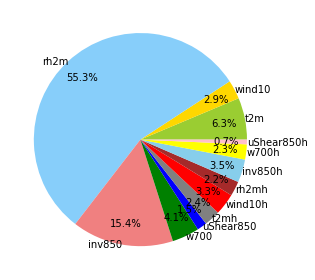

In [87]:

labels = ["t2m","wind10","rh2m","inv850","w700","uShear850","t2mh","wind10h","rh2mh",
          "inv850h","w700h","uShear850h"]
sizes = np.mean(f_imp, axis=1)
#print(sizes)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','green','blue','grey','red','brown','skyblue','yellow','pink']
plt.pie(sizes, labels=labels,colors=colors, autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.0)

#patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
#plt.legend(patches, labels, loc="best")
#plt.axis('equal')
plt.tight_layout()
#plt.show()
plt.savefig('GradBoostAllDays.png')

y_pred=reg.predict(X)
y_pred_test=reg.predict(X_test)
y_pred_train=reg.predict(X_train)

print(np.corrcoef(y,y_pred))
print(np.corrcoef(y_train,y_pred_train))
print(np.corrcoef(y_test,y_pred_test))


np.savetxt("y_predGradBoost.txt",y_pred,fmt='%0.3f')
